# S2RA_ETBF_doc_test_export

**Date:** <br>
23 February 2022 <br>
**Background:** <br>
Issue -  <br>
**Author(s):**<br>
Thomas Moore<br>

### OOD documentation
https://opus.nci.org.au/display/DAE/Setting+up+a+Dask+Cluster+on+OOD

In [1]:
Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

In [2]:
import xarray as xr
import numpy as np
import xrft
import xesmf as xe
import scipy
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import re
import cartopy.crs as ccrs
import proplot as pplt
from rechunker import rechunk
%config Completer.use_jedi = False

## import helper

In [3]:
import importlib.util
spec = importlib.util.spec_from_file_location("helper", "/g/data/v14/tm4888/code/helper-py/helper_tools.py")
helper = importlib.util.module_from_spec(spec)
spec.loader.exec_module(helper)

## OOD cluster

In [4]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=1,processes=1,memory="23GB",walltime='02:00:00')
client = Client(cluster)
cluster.scale(cores=12)

/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.131:41493,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# load final ETBF S2 025grid collections from zarr

In [6]:
%%time
ds = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.masked.AUSWCPregion.ETBFvars.zarr',consolidated=True)

CPU times: user 304 ms, sys: 68.6 ms, total: 372 ms
Wall time: 1.2 s


In [7]:
ds = ds.drop_vars(['areat','areau','areav','maskT','maskU','maskV'])
ds

<xarray.Dataset>
Dimensions:        (time: 492, lat: 361, lon: 721)
Coordinates:
  * lat            (lat) float64 -70.0 -69.75 -69.5 -69.25 ... 19.5 19.75 20.0
  * lon            (lon) float64 90.0 90.25 90.5 90.75 ... 269.5 269.8 270.0
  * time           (time) datetime64[ns] 1981-01-15 1981-02-15 ... 2021-12-15
Data variables: (12/18)
    d20            (time, lat, lon) float32 dask.array<chunksize=(12, 361, 721), meta=np.ndarray>
    eke2000        (time, lat, lon) float32 dask.array<chunksize=(1, 361, 721), meta=np.ndarray>
    eke300         (time, lat, lon) float32 dask.array<chunksize=(1, 361, 721), meta=np.ndarray>
    hc300          (time, lat, lon) float32 dask.array<chunksize=(12, 361, 721), meta=np.ndarray>
    mld1           (time, lat, lon) float32 dask.array<chunksize=(12, 361, 721), meta=np.ndarray>
    mld2           (time, lat, lon) float32 dask.array<chunksize=(12, 361, 721), meta=np.ndarray>
    ...             ...
    temp50         (time, lat, lon) float32 dask.array<chunksize=(12, 361, 721), meta=np.ndarray>
    temp500        (time, lat, lon) float32 dask.array<chunksize=(12, 361, 721), meta=np.ndarray>
    u100           (time, lat, lon) float32 dask.array<chunksize=(1, 361, 721), meta=np.ndarray>
    u100_300       (time, lat, lon) float32 dask.array<chunksize=(1, 361, 721), meta=np.ndarray>
    v100           (time, lat, lon) float32 dask.array<chunksize=(1, 361, 721), meta=np.ndarray>
    v100_300       (time, lat, lon) float32 dask.array<chunksize=(1, 361, 721), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# Tests $\Downarrow$

In [46]:
# Test for zeroes
for varname, da in ds.data_vars.items():
    if (ds[varname] == 0).any():
        raise ValueError(varname + " variable has a zero value <<<")
    else:
        print('No zero values found in '+varname)

No zero values found in d20
No zero values found in eke2000
No zero values found in eke300
No zero values found in hc300
No zero values found in mld1
No zero values found in mld2
No zero values found in ssh_corrected
No zero values found in sss
No zero values found in sst
No zero values found in td
No zero values found in temp100
No zero values found in temp200
No zero values found in temp50
No zero values found in temp500
No zero values found in u100
No zero values found in u100_300
No zero values found in v100
No zero values found in v100_300


In [47]:
# Test for negative values
for varname, da in ds.data_vars.items():
    if (ds[varname] < 0).any():
        print(varname + " variable has negative values <<<")
    else:
        print('No negative values found in '+varname)

No negative values found in d20
No negative values found in eke2000
No negative values found in eke300
hc300 variable has negative values <<<
No negative values found in mld1
No negative values found in mld2
ssh_corrected variable has negative values <<<
No negative values found in sss
sst variable has negative values <<<
No negative values found in td
temp100 variable has negative values <<<
temp200 variable has negative values <<<
temp50 variable has negative values <<<
temp500 variable has negative values <<<
u100 variable has negative values <<<
u100_300 variable has negative values <<<
v100 variable has negative values <<<
v100_300 variable has negative values <<<


In [20]:
# Test for all hc300 time slices for negative values
size = len(ds.time)
for slice_i in range(0, size):
    if not (ds.hc300.isel(time=slice_i) < 0).any():
        print("slice " + str(slice_i) + " has no negative values")

slice 480 has no negative values
slice 481 has no negative values
slice 482 has no negative values
slice 483 has no negative values
slice 484 has no negative values
slice 485 has no negative values
slice 486 has no negative values
slice 487 has no negative values
slice 488 has no negative values
slice 489 has no negative values
slice 490 has no negative values
slice 491 has no negative values


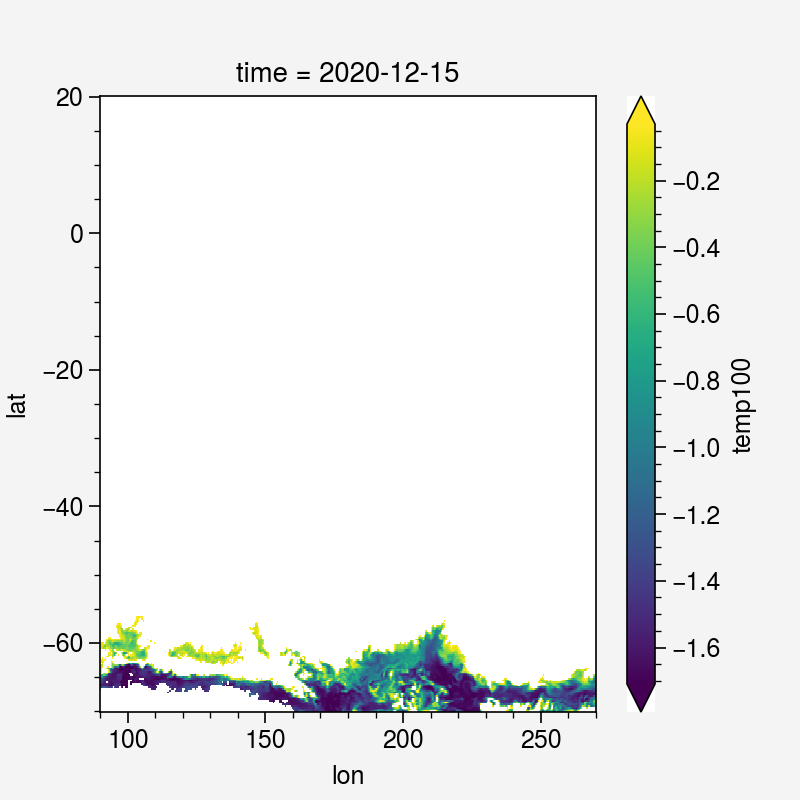

In [38]:
ds.temp100.isel(time=479).where(ds.temp100.isel(time=479) < 0).plot(robust=True)

# Tests $\Uparrow$

# 

# Write out single zarr collection

In [ ]:
%%time
ds_TUV.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.ETBFvars_025deg.zarr',consolidated=True)

# $ The\ End$

# Break glass in case of emergency
# $\Downarrow$

In [ ]:
client.restart()

In [44]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [ ]:
client.restart()